In [1]:
import torch
import torch.nn as nn

In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

#train and test data directory
train_dir = './images'

# load the train and test data


# also make 1 grayscale

dataset = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Grayscale()
    ,transforms.ToTensor()
]))

In [3]:
dataset.classes

['-15', '-30', '-60', '0', '15', '30', '60']

In [10]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 5366
    Root location: ./images
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


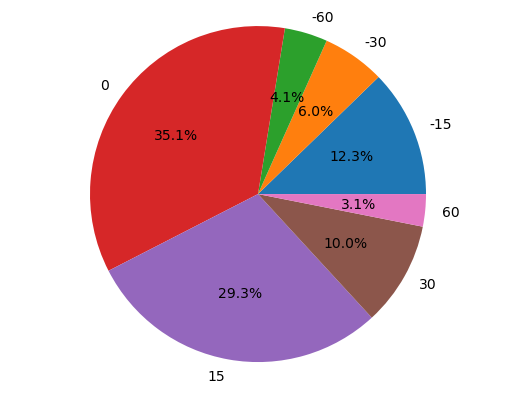

In [9]:
# check balance of the dataset

from collections import Counter
Counter(dataset.targets)

# create pieplot
import matplotlib.pyplot as plt
import numpy as np

labels, values = zip(*Counter(dataset.targets).items())
# change the labels index to the class names

indexes = np.arange(len(labels))
width = 1

plt.pie(values, labels=dataset.classes, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

torch.Size([1, 50, 125]) 0


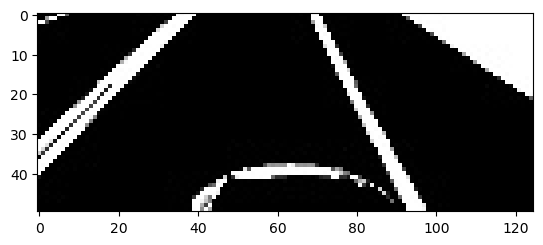

In [4]:
# show first image using matplotlib

import matplotlib.pyplot as plt

image, label = dataset[320]
print(image.shape,label)
plt.imshow(image.permute(1,2,0), cmap='gray')


In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 5366
    Root location: ./images
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [34]:
class CNN(nn.Module):
    def __init__(self, n_actions):
        super(CNN, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=2)

        # Calculate the size after convolutional layers

        # Fully connected layers
        self.fc1 = nn.Linear(140, 64)
        self.fc2 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)
        x = torch.relu(self.conv2(x))

        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [35]:
# Example usage:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = CNN(n_actions=7).to(device)


In [36]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [37]:
# Data loader
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=64)


In [38]:
from torch.autograd import Variable
# Train the model

num_epochs = 1000
total_step = len(train_loader)


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))
    
    

Epoch [10/1000], Loss: 3.1129
Epoch [20/1000], Loss: 2.7422


In [ ]:
# calculate accuracy

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the train images: {} %'.format(100 * correct / total))

Accuracy of the model on the train images: 95.4250295159386 %


In [ ]:
# save the model
torch.save(model.state_dict(), 'sp_model.pth')
print('Model saved to sp_model.pth')

Model saved to sp_model.pth
